In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from jitcdde import jitcdde, y, t, C

import seaborn as sns
sns.set(font_scale = 1.5, rc={"lines.linewidth":2})

ImportError: cannot import name 'C' from 'jitcdde' (C:\Users\kangu_g0sl2ax\AppData\Roaming\Python\Python312\site-packages\jitcdde\__init__.py)

# **Model:**

Our model is made up of the following three quantities:

$$
\begin{align}
M(t) &= \mathrm{mRNA} \\
B(t) &= \mathrm{\beta-galactosidase} \\
A(t) &= \mathrm{allolactose} \\
\end{align}
$$

The three variable ODE model is as follows:

$$
\begin{align}
\frac{d\mathrm{M}}{d\mathrm{t}} &= \alpha_{M}\frac{1 + K_{1}(\mathrm{e}^{-\mu\tau_{M}}A_{\tau_M})^n}{K + K_{1}(\mathrm{e}^{-\mu\tau_{M}}A_{\tau_M})^n} - \tilde{\gamma}_{M} M \tag{1} \\
\frac{d\mathrm{B}}{d\mathrm{t}} &= \alpha_{B} \mathrm{e}^{-\mu \tau_{B}} M_{\tau_B} - \tilde{\gamma}_{B} B \tag{2} \\
\frac{d\mathrm{A}}{d\mathrm{t}} &= \alpha_{A} B \frac{L}{K_{L} + L} - \beta_{A} B \frac{A}{K_{A} + A} - \tilde{\gamma}_{A} A \tag{3}
\end{align}
$$

Where these are delay differential equations (discrete time delays are due to the transcription and translation processes)

# **Biological Meaning of Each Term:**

## For Equation 1 (ODE for mRNA):

**degradation term:**

$\tilde{\gamma}_{M} M = \gamma_{M} M + \mu M$ and represents the loss of mRNA due to degradation and dilution from bacterial growth.

**production term:**

$\tau_M$ is a constant that represents the time delay of mRNA production due to transcription of mRNA from DNA, and must be greater than zero.  $A_{\tau M} = A(t-\tau_{M})$

The term $\mathrm{e}^{-\mu\tau_{M}}A_{\tau M}$ represents the concetration of allolactose (A) at time $t-\tau_{M}$ and its dilution due to bacterial growth.

The production rate of mRNA is proportional to the fraction of free operator sites, which is given by the expression $\frac{1 + K_1 [A]^n}{2}$

## For Equation 2 (ODE for ß-galactosidase):

**degradation term:**

$\tilde{\gamma}_{B} B = \gamma_{B} B + \mu B$ and represents loss of ß-galactosidase due to degradation and dilution due to bacterial growth.

**production term:**

$\tau_B$ is a constant that represents the time delay of ß-galactosidase production due to tranlastion from mRNA, and must be greater than zero.  $M_{\tau_B} = M(t-\tau_{B})$

The production rate of ß-galactosidase should be proportional to the mRNA concentration, accounting for the $M_{\tau_B}$ in the production term.

In total, $\mathrm{e}^{-\mu \tau_{B}} M_{\tau_B}$ models the increase in ß-galactosidase concentration from tranlastion from mRNA while accounting for the time-delay in transcription. 

For Equation 3 (ODE for allolactose):

**degradation term:**

$\tilde{\gamma}_{A} A = \gamma_{A} A + \mu A$ and represents loss of allolactose due to degradation and dilution due to bacterial growth.

**production term:**

The $\frac{L}{K_{L} + L}$ term models the production of allolactose from the reaction catalyzed by ß-galactosidase to produce allolactose from lactose.

The $\beta_{A} B \frac{A}{K_{A} + A}$ term models the loss of allolactose from the reverse reaction, where ß-galactosidase catalyzes the reaction to form glucose and galactose from allolactose.

# **Paramters:**
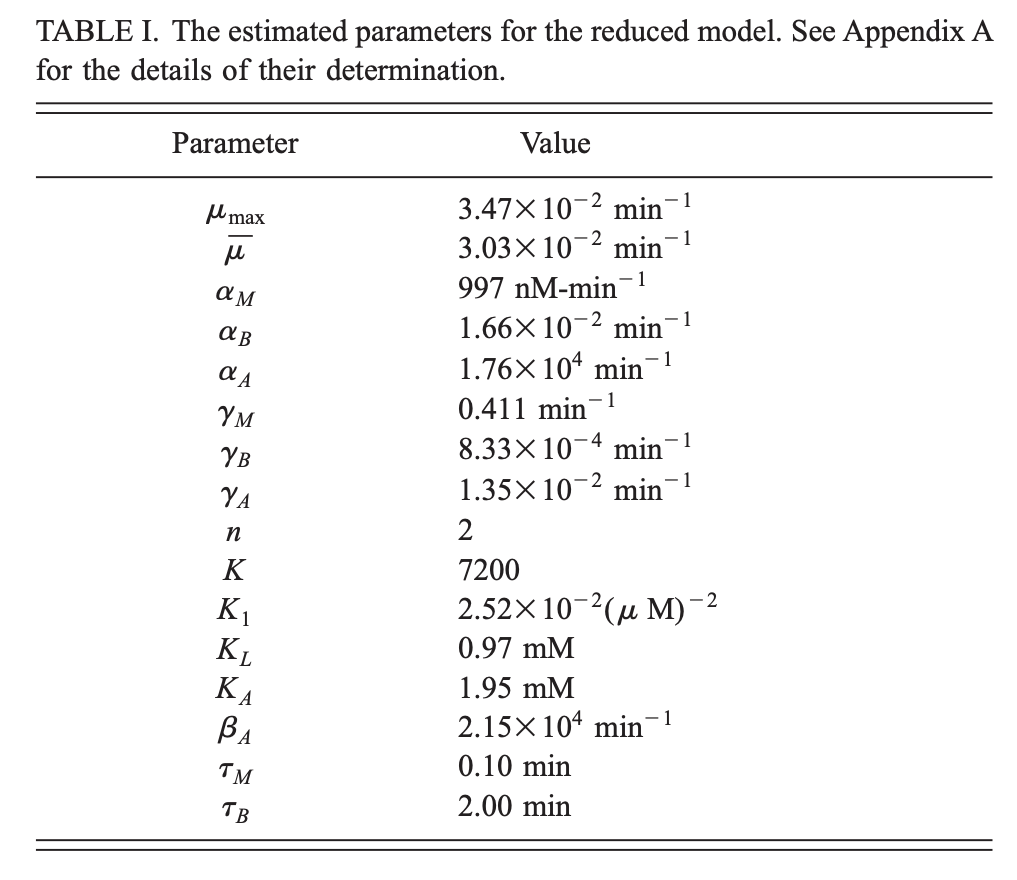

# Bifurcation Analysis:

First, we need to set all of our differential equations equal to zero

$$
\begin{align}
0 &= \alpha_{M}\frac{1 + K_{1}(\mathrm{e}^{-\mu\tau_{M}}A_{\tau_M})^n}{K + K_{1}(\mathrm{e}^{-\mu\tau_{M}}A_{\tau_M})^n} - \tilde{\gamma}_{M} M  \\
0 &= \alpha_{B} \mathrm{e}^{-\mu \tau_{B}} M_{\tau_B} - \tilde{\gamma}_{B} B \\
0 &= \alpha_{A} B \frac{L}{K_{L} + L} - \beta_{A} B \frac{A}{K_{A} + A} - \tilde{\gamma}_{A} A 
\end{align}
$$

Do we want to solve this or just cite the paper?  The paper used an internal lactose concentration (L) of 50 µM and got these values:

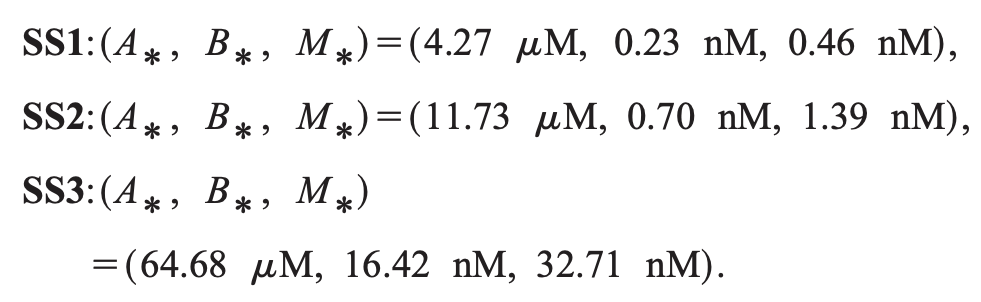

## AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA ##

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

In [251]:
# define L
L = 50e-6 # M

In [258]:
# define parameters
gamma_m = 0.411 # min^-1
gamma_b = 0.000833 # min^-1
gamma_a = 0.0135 # min^-1
alpha_m = 9.97e-7 # M/min
alpha_b = 0.0166 # min^-1 
alpha_a = 17600 # min^-1
n = 2
K = 7200
K1 = 2.52e10
KL = 0.00097 # M
KA = 0.00195 # M
beta_a = 21500 # min^-1
tauM = 0.1 # min
tauB = 2 # min
mu = 0.0303 # min^-1
params = (
    L, gamma_m, gamma_b, gamma_a, 
    alpha_m, alpha_b, alpha_a, 
    n, K, K1, KL, KA, 
    beta_a, tauM, tauB, mu
)

In [253]:
# initial conditions
M_0 = 2.3e-10 # M
B_0 = 1.1e-6 # M
A_0 = 1.7e-7 # M
init = [M_0, B_0, A_0]

In [254]:
# integration period
ti = 0
tf = 1000
dt = 0.1

In [255]:
def model(C, t, L, g_m, g_b, g_a, a_m, a_b, a_a, n, k, k1, kL, kA, b_a, t_M, t_B, mu):
    '''
    models the delayed differential equation for the concentrations of A, B, and M
    '''

    # make everything function of concentration
    M, B, A = C(t)
    
    # delayed values [M,B,A] also make sure not negative
    A_tauM = max(0,C(t - t_M)[2])
    M_tauB = max(0,C(t - t_B)[0])

    # equations
    dM_dt = a_m * ((1 + (k1 * (np.exp(-mu * t_M) * A_tauM)**n)) / 
                   (k + (k1 * (np.exp(-mu * t_M) * A_tauM)**n))) - (g_m * M + mu * M)
    dB_dt = a_b*(np.exp(-mu*t_B))*M_tauB - (g_b*B + mu*B)
    dA_dt = a_a*B*(L/(kL + L)) - b_a*B*(A/(kA + A)) - (g_a*A + mu*A)
    
    # return results
    return [dM_dt, dB_dt, dA_dt]

def history(t):
    ''' 
    constant function
    '''
    return init

In [256]:
# use ddeint to solve the DDE
t_span = np.arange(ti, tf, dt)
sol = np.maximum(ddeint(model, history, t_span, fargs=params),0)

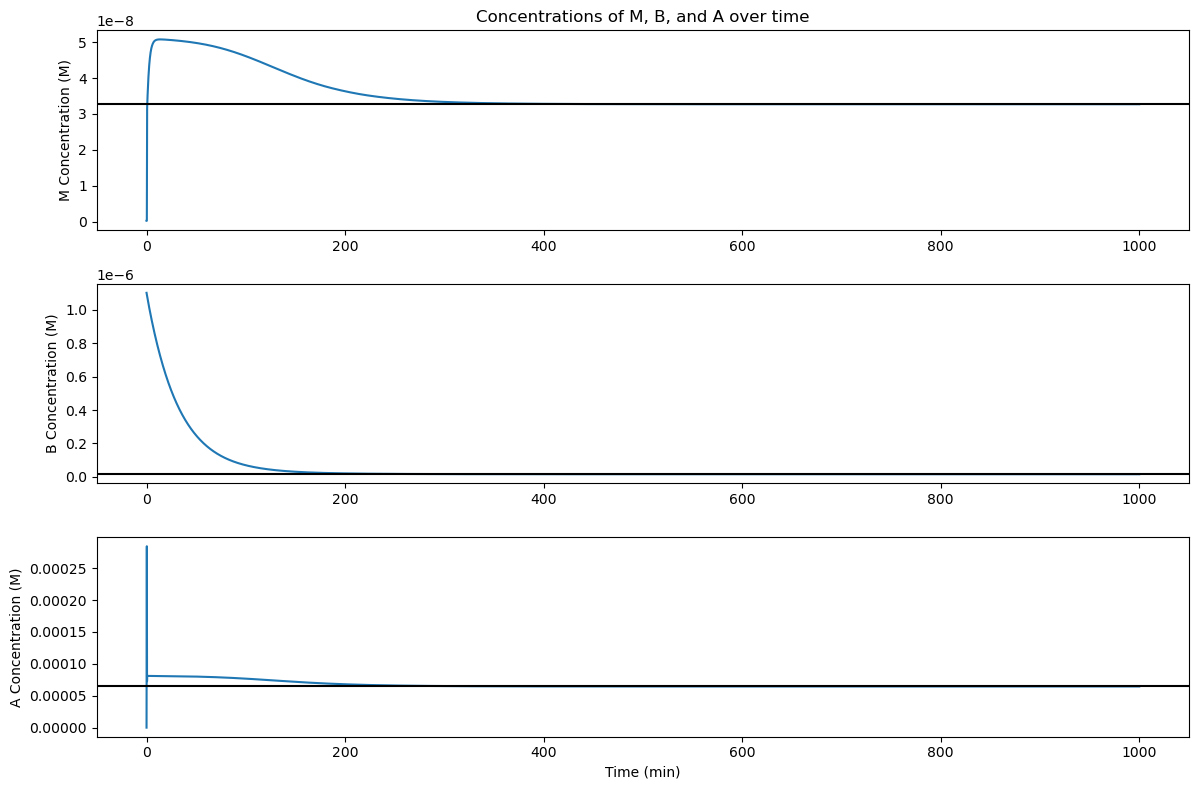

In [257]:
# Set up pyplot
plt.figure(figsize=(12, 8))

# Plot M
plt.subplot(3, 1, 1)
plt.plot(t_span, sol[:, 0])
plt.title('Concentrations of M, B, and A over time')
plt.ylabel('M Concentration (M)')
plt.axhline(32.71e-9, color = 'k')

# Plot B
plt.subplot(3, 1, 2)
plt.plot(t_span, sol[:, 1])
plt.ylabel('B Concentration (M)')
plt.axhline(16.42e-9, color = 'k')

# Plot A
plt.subplot(3, 1, 3)
plt.plot(t_span, sol[:, 2])
plt.ylabel('A Concentration (M)')
plt.xlabel('Time (min)')
plt.axhline(64.68e-6, color = 'k')

plt.tight_layout()
plt.show()

I swear to god it took me forever to get this to properly generate a steady state and it doesn't match the one the paper gave.